# Heavy-Hexagon Lattice
Define heavy-hexagon lattices with various geometries so that we can run DMRG and iDMRG. We need to be careful, as there are many ways to define the lattice vectors. The lattice vectors will define the unit cells for infinite cylinders.

In [1]:
import sys
sys.path.append("/home/sajant/tenpy")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from copy import deepcopy
import csv

In [3]:
import tenpy
from tenpy.networks.site import SpinHalfSite, GroupedSite
from tenpy.networks.mps import TransferMatrix, MPS
from tenpy.models.model import CouplingMPOModel, NearestNeighborModel
from tenpy.networks.terms import CouplingTerms
import tenpy.models.lattice as lattice
from tenpy.models.lattice import Lattice, TrivialLattice
from tenpy.models.tf_ising import TFIModel
from tenpy.models.spins import SpinModel
import tenpy.linalg.np_conserved as npc
from tenpy.algorithms import dmrg
from tenpy.algorithms.mpo_evolution import ExpMPOEvolution
from tenpy.algorithms.tdvp import TwoSiteTDVPEngine, SingleSiteTDVPEngine

/home/sajant/tenpy/tenpy/tools/optimization.py:307: UserWarning: Couldn't load compiled cython code. Code will run a bit slower.
  warnings.warn("Couldn't load compiled cython code. Code will run a bit slower.")


In [4]:
tenpy.tools.misc.setup_logging(to_stdout='INFO')

# Build Lattice

In [61]:
class HH_Lattice_zigzag(Lattice):
    """
    0
    9
    8
  6' 7 6
      5
      4
      2
  3' 1 3
    0
    """
    
    dim = 2  #: the dimension of the lattice
    Lu = 10
    
    def __init__(self, Lx, Ly, sites, **kwargs):
        sites = lattice._parse_sites(sites, self.Lu)
        s3 = 3**0.5
        basis = np.array(([2*s3, 0.], [0, 6.]))
        pos = (np.array([0.,0.]), np.array([s3/2.,0.5]), np.array([s3,1.]), np.array([3*s3/2, 0.5]),
               np.array([s3,2.]), np.array([s3,3.]), np.array([3*s3/2,3.5]), np.array([s3/2,3.5]),
               np.array([0,4]), np.array([0,5]))
        kwargs.setdefault('basis', basis)
        kwargs.setdefault('positions', pos)
        NN = [(0, 1, np.array([0, 0])), (1, 2, np.array([0, 0])), (2, 3, np.array([0, 0])), (2, 4, np.array([0, 0])),
              (4, 5, np.array([0, 0])), (5, 6, np.array([0, 0])), (5, 7, np.array([0, 0])), (7, 8, np.array([0, 0])),
              (8, 9, np.array([0, 0])), (9, 0, np.array([0, 1])), (3, 0, np.array([1, 0])), (6, 8, np.array([1, 0]))] # J1
        nNN = [(1, 3, np.array([0, 0])), (1, 4, np.array([0, 0])), (3, 4, np.array([0, 0])), (4, 6, np.array([0, 0])),
               (4, 7, np.array([0, 0])), (6, 7, np.array([0, 0])), (7, 9, np.array([0, 0])), (3, 1, np.array([1, 0])),
               (9, 1, np.array([0, 1])), (9, 3, np.array([-1, 1])), (6, 7, np.array([1, 0])), (6, 9, np.array([1, 0]))]
        nnNN = [(0, 2, np.array([0, 0])), (2, 5, np.array([0, 0])), (5, 8, np.array([0, 0])),
                (8, 0, np.array([0, 1])), (5, 8, np.array([1, 0])), (2, 0, np.array([1, 0]))] #J3
        
        kwargs.setdefault('pairs', {})
        kwargs['pairs'].setdefault('nearest_neighbors', NN)
        kwargs['pairs'].setdefault('next_nearest_neighbors', nNN)
        kwargs['pairs'].setdefault('next_next_nearest_neighbors', nnNN)
        Lattice.__init__(self, [Lx, Ly], sites, **kwargs)

    def ordering(self, order):
        if isinstance(order, np.ndarray):
            return order
        return super().ordering(order)

class HH_Lattice_armchair(Lattice):    
    dim = 2  #: the dimension of the lattice
    Lu = 10
    
    def __init__(self, Lx, Ly, sites, **kwargs):
        sites = lattice._parse_sites(sites, self.Lu)
        s3 = 3**0.5
        basis = np.array(([6, 0], [0, 2.*s3]))
        pos = (np.array([0.,0.]), np.array([0.5,s3/2]), np.array([0.5,-s3/2]), np.array([1.,-s3]),
               np.array([2.,-s3]), np.array([3.,-s3]), np.array([3.5,-s3/2]), np.array([4.,0.]),
               np.array([3.5,s3/2]), np.array([5.,0.]))
        kwargs.setdefault('basis', basis)
        kwargs.setdefault('positions', pos)
        NN = [(0, 1, np.array([0, 0])), (0, 2, np.array([0, 0])), (2, 3, np.array([0, 0])), (3, 4, np.array([0, 0])),
              (4, 5, np.array([0, 0])), (5, 6, np.array([0, 0])), (6, 7, np.array([0, 0])), (7, 8, np.array([0, 0])),
              (7, 9, np.array([0, 0])), (9, 0, np.array([1, 0])), (1, 3, np.array([0, 1])), (8, 5, np.array([0, 1]))] # J1
        nNN = [(1, 2, np.array([0, 0])), (2, 4, np.array([0, 0])), (4, 6, np.array([0, 0])), (6, 8, np.array([0, 0])),
               (6, 9, np.array([0, 0])), (8, 9, np.array([0, 0])), (9, 1, np.array([1, 0])), (9, 2, np.array([1, 0])),
               (2, 1, np.array([0, -1])), (4, 1, np.array([0, -1])), (4, 8, np.array([0, -1])), (6, 8, np.array([0, -1]))]
        nnNN = [(0, 3, np.array([0, 0])), (3, 5, np.array([0, 0])), (5, 7, np.array([0, 0])),
                (7, 0, np.array([1, 0])), (3, 0, np.array([0, -1])), (5, 7, np.array([0, -1]))] #J3
        
        kwargs.setdefault('pairs', {})
        kwargs['pairs'].setdefault('nearest_neighbors', NN)
        kwargs['pairs'].setdefault('next_nearest_neighbors', nNN)
        kwargs['pairs'].setdefault('next_next_nearest_neighbors', nnNN)
        Lattice.__init__(self, [Lx, Ly], sites, **kwargs)

    def ordering(self, order):
        if isinstance(order, np.ndarray):
            return order
        return super().ordering(order)  

In [62]:
lat = HH_Lattice_zigzag(2, 2, None, bc='open')

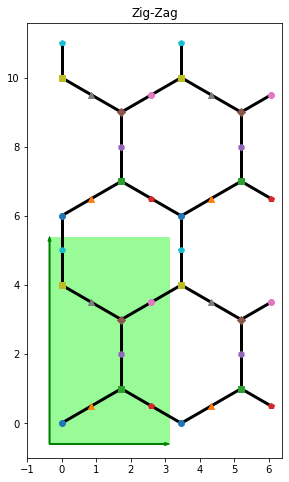

In [63]:
plt.figure(figsize=(6, 8))
ax = plt.gca()
lat.plot_coupling(ax, linestyle='-', linewidth=3, label='nearest_neighbors')
lat.plot_sites(ax)
lat.plot_basis(ax, origin=-0.1*(lat.basis[0] + lat.basis[1]))
ax.set_aspect('equal')
ax.set_xlim(-1)
ax.set_ylim(-1)
ax.set_title('Zig-Zag')
plt.show()

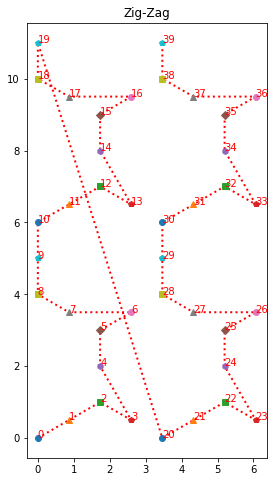

In [64]:
plt.figure(figsize=(6, 8))
ax = plt.gca()
lat.plot_order(ax, linestyle=':', linewidth=2)
lat.plot_sites(ax)
ax.set_title('Zig-Zag')
ax.set_aspect('equal')
plt.show()

In [65]:
lat2 = HH_Lattice_armchair(2, 2, None, bc='open')

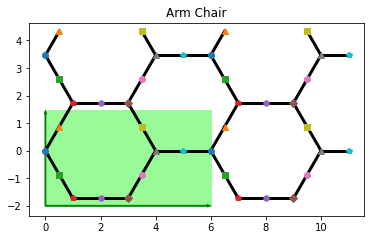

In [66]:
plt.figure(figsize=(6, 8))
ax = plt.gca()
#lat = lattice.Honeycomb(4, 4, None, bc='periodic')
lat2.plot_coupling(ax, linestyle='-', linewidth=3, label='nearest_neighbors')
lat2.plot_sites(ax)
lat2.plot_basis(ax, origin=np.array([0, -2]))
ax.set_aspect('equal')
#ax.set_xlim(-2)
#ax.set_ylim(-1)
ax.set_title('Arm Chair')
#ax.legend(loc='upper left')
plt.show()

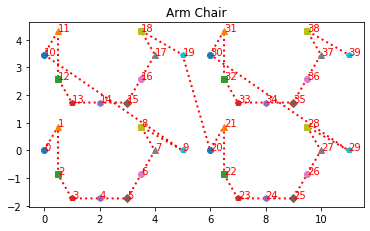

In [67]:
plt.figure(figsize=(6, 8))
ax = plt.gca()
lat2.plot_order(ax, linestyle=':', linewidth=2)
lat2.plot_sites(ax)
ax.set_title('Arm Chair')
ax.set_aspect('equal')
plt.show()

# Make J1-J2-J3 model

In [69]:
class HH_J1J2J3(CouplingMPOModel):
    default_lattice = HH_Lattice_zigzag
    force_default_lattice = False
    
    def init_sites(self, model_params):
        conserve = model_params.get('conserve', 'Sz')
        if conserve == 'best':
            conserve = 'Sz'
            self.logger.info("%s: set conserve to %s", self.name, conserve)
        site = SpinHalfSite(conserve=conserve)
        return site
    
    def init_terms(self, model_params):       
        J1 = model_params.get('J1', 1.0)
        J2 = model_params.get('J2', 0.0)
        J3 = model_params.get('J3', 0.0)

        for u1, u2, dx in self.lat.pairs['nearest_neighbors']:
            self.add_coupling(J1, u1, 'Sx', u2, 'Sx', dx, category='J1')
            self.add_coupling(J1, u1, 'Sy', u2, 'Sy', dx, category='J1')
            self.add_coupling(J1, u1, 'Sz', u2, 'Sz', dx, category='J1')
            
        for u1, u2, dx in self.lat.pairs['next_nearest_neighbors']:
            self.add_coupling(J1, u1, 'Sx', u2, 'Sx', dx, category='J2')
            self.add_coupling(J1, u1, 'Sy', u2, 'Sy', dx, category='J2')
            self.add_coupling(J1, u1, 'Sz', u2, 'Sz', dx, category='J2')
            
        for u1, u2, dx in self.lat.pairs['next_next_nearest_neighbors']:
            self.add_coupling(J1, u1, 'Sx', u2, 'Sx', dx, category='J3')
            self.add_coupling(J1, u1, 'Sy', u2, 'Sy', dx, category='J3')
            self.add_coupling(J1, u1, 'Sz', u2, 'Sz', dx, category='J3')

## Check correctness of Finite Models

### Zig-Zag

In [70]:
model_fin = HH_J1J2J3({'Lx':2, 'Ly':2, 'J1': 1.0, 'J2': 0.0, 'J3': 0.0, 'bc_MPS':'finite', 
                   'conserve':None, 'lattice': HH_Lattice_zigzag, 'bc_x': 'open', 'bc_y': 'open'})
print(np.max(model_fin.H_MPO.chi))

INFO    : HH_J1J2J3: reading 'lattice'=<class '__main__.HH_Lattice_zigzag'>
INFO    : HH_J1J2J3: reading 'bc_MPS'='finite'
INFO    : HH_J1J2J3: reading 'conserve'=None
INFO    : HH_J1J2J3: reading 'bc_x'='open'
INFO    : HH_J1J2J3: reading 'Lx'=2
INFO    : HH_J1J2J3: reading 'Ly'=2
INFO    : HH_J1J2J3: reading 'bc_y'='open'
INFO    : HH_J1J2J3: reading 'J1'=1.0
INFO    : HH_J1J2J3: reading 'J2'=0.0
INFO    : HH_J1J2J3: reading 'J3'=0.0
32


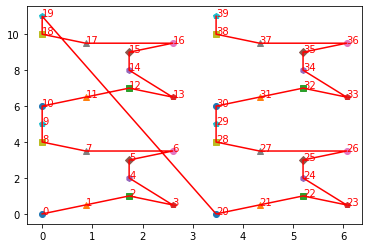

In [71]:
fig = plt.figure()
ax = fig.gca()
model_fin.lat.plot_sites(ax)
model_fin.lat.plot_order(ax)

In [72]:
model_fin.coupling_terms

{'J1': <tenpy.networks.terms.CouplingTerms at 0x7f3f770ec7f0>,
 'J2': <tenpy.networks.terms.CouplingTerms at 0x7f3f7747cd30>,
 'J3': <tenpy.networks.terms.CouplingTerms at 0x7f3f770ec880>}

[[('Sx', 0), ('Sx', 1)],
 [('Sy', 0), ('Sy', 1)],
 [('Sz', 0), ('Sz', 1)],
 [('Sx', 1), ('Sx', 2)],
 [('Sy', 1), ('Sy', 2)],
 [('Sz', 1), ('Sz', 2)],
 [('Sx', 2), ('Sx', 3)],
 [('Sx', 2), ('Sx', 4)],
 [('Sy', 2), ('Sy', 3)],
 [('Sy', 2), ('Sy', 4)],
 [('Sz', 2), ('Sz', 3)],
 [('Sz', 2), ('Sz', 4)],
 [('Sx', 3), ('Sx', 20)],
 [('Sy', 3), ('Sy', 20)],
 [('Sz', 3), ('Sz', 20)],
 [('Sx', 4), ('Sx', 5)],
 [('Sy', 4), ('Sy', 5)],
 [('Sz', 4), ('Sz', 5)],
 [('Sx', 5), ('Sx', 6)],
 [('Sx', 5), ('Sx', 7)],
 [('Sy', 5), ('Sy', 6)],
 [('Sy', 5), ('Sy', 7)],
 [('Sz', 5), ('Sz', 6)],
 [('Sz', 5), ('Sz', 7)],
 [('Sx', 6), ('Sx', 28)],
 [('Sy', 6), ('Sy', 28)],
 [('Sz', 6), ('Sz', 28)],
 [('Sx', 7), ('Sx', 8)],
 [('Sy', 7), ('Sy', 8)],
 [('Sz', 7), ('Sz', 8)],
 [('Sx', 8), ('Sx', 9)],
 [('Sy', 8), ('Sy', 9)],
 [('Sz', 8), ('Sz', 9)],
 [('Sx', 9), ('Sx', 10)],
 [('Sy', 9), ('Sy', 10)],
 [('Sz', 9), ('Sz', 10)],
 [('Sx', 10), ('Sx', 11)],
 [('Sy', 10), ('Sy', 11)],
 [('Sz', 10), ('Sz', 11)],
 [('Sx', 1

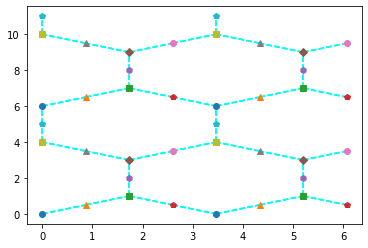

In [73]:
fig = plt.figure()
ax = fig.gca()
model_fin.coupling_terms['J1'].plot_coupling_terms(ax, model_fin.lat)
model_fin.lat.plot_sites(ax)
model_fin.coupling_terms['J1'].to_TermList().terms

[[('Sx', 1), ('Sx', 3)],
 [('Sx', 1), ('Sx', 4)],
 [('Sy', 1), ('Sy', 3)],
 [('Sy', 1), ('Sy', 4)],
 [('Sz', 1), ('Sz', 3)],
 [('Sz', 1), ('Sz', 4)],
 [('Sx', 3), ('Sx', 4)],
 [('Sx', 3), ('Sx', 21)],
 [('Sy', 3), ('Sy', 4)],
 [('Sy', 3), ('Sy', 21)],
 [('Sz', 3), ('Sz', 4)],
 [('Sz', 3), ('Sz', 21)],
 [('Sx', 4), ('Sx', 6)],
 [('Sx', 4), ('Sx', 7)],
 [('Sy', 4), ('Sy', 6)],
 [('Sy', 4), ('Sy', 7)],
 [('Sz', 4), ('Sz', 6)],
 [('Sz', 4), ('Sz', 7)],
 [('Sx', 6), ('Sx', 7)],
 [('Sx', 6), ('Sx', 27)],
 [('Sx', 6), ('Sx', 29)],
 [('Sy', 6), ('Sy', 7)],
 [('Sy', 6), ('Sy', 27)],
 [('Sy', 6), ('Sy', 29)],
 [('Sz', 6), ('Sz', 7)],
 [('Sz', 6), ('Sz', 27)],
 [('Sz', 6), ('Sz', 29)],
 [('Sx', 7), ('Sx', 9)],
 [('Sy', 7), ('Sy', 9)],
 [('Sz', 7), ('Sz', 9)],
 [('Sx', 9), ('Sx', 11)],
 [('Sy', 9), ('Sy', 11)],
 [('Sz', 9), ('Sz', 11)],
 [('Sx', 11), ('Sx', 13)],
 [('Sx', 11), ('Sx', 14)],
 [('Sy', 11), ('Sy', 13)],
 [('Sy', 11), ('Sy', 14)],
 [('Sz', 11), ('Sz', 13)],
 [('Sz', 11), ('Sz', 14)],
 

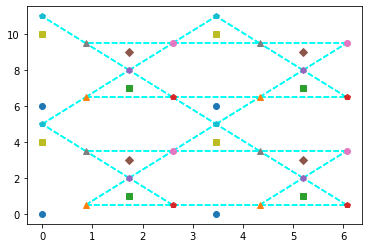

In [74]:
fig = plt.figure()
ax = fig.gca()
model_fin.coupling_terms['J2'].plot_coupling_terms(ax, model_fin.lat)
model_fin.lat.plot_sites(ax)
model_fin.coupling_terms['J2'].to_TermList().terms

[[('Sx', 0), ('Sx', 2)],
 [('Sy', 0), ('Sy', 2)],
 [('Sz', 0), ('Sz', 2)],
 [('Sx', 2), ('Sx', 5)],
 [('Sx', 2), ('Sx', 20)],
 [('Sy', 2), ('Sy', 5)],
 [('Sy', 2), ('Sy', 20)],
 [('Sz', 2), ('Sz', 5)],
 [('Sz', 2), ('Sz', 20)],
 [('Sx', 5), ('Sx', 8)],
 [('Sx', 5), ('Sx', 28)],
 [('Sy', 5), ('Sy', 8)],
 [('Sy', 5), ('Sy', 28)],
 [('Sz', 5), ('Sz', 8)],
 [('Sz', 5), ('Sz', 28)],
 [('Sx', 8), ('Sx', 10)],
 [('Sy', 8), ('Sy', 10)],
 [('Sz', 8), ('Sz', 10)],
 [('Sx', 10), ('Sx', 12)],
 [('Sy', 10), ('Sy', 12)],
 [('Sz', 10), ('Sz', 12)],
 [('Sx', 12), ('Sx', 15)],
 [('Sx', 12), ('Sx', 30)],
 [('Sy', 12), ('Sy', 15)],
 [('Sy', 12), ('Sy', 30)],
 [('Sz', 12), ('Sz', 15)],
 [('Sz', 12), ('Sz', 30)],
 [('Sx', 15), ('Sx', 18)],
 [('Sx', 15), ('Sx', 38)],
 [('Sy', 15), ('Sy', 18)],
 [('Sy', 15), ('Sy', 38)],
 [('Sz', 15), ('Sz', 18)],
 [('Sz', 15), ('Sz', 38)],
 [('Sx', 20), ('Sx', 22)],
 [('Sy', 20), ('Sy', 22)],
 [('Sz', 20), ('Sz', 22)],
 [('Sx', 22), ('Sx', 25)],
 [('Sy', 22), ('Sy', 25)],
 

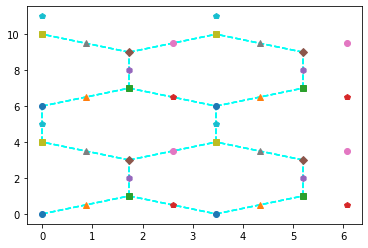

In [75]:
fig = plt.figure()
ax = fig.gca()
model_fin.coupling_terms['J3'].plot_coupling_terms(ax, model_fin.lat)
model_fin.lat.plot_sites(ax)
model_fin.coupling_terms['J3'].to_TermList().terms

### Arm Chair

In [76]:
model_fin = HH_J1J2J3({'Lx':2, 'Ly':2, 'J1': 1.0, 'J2': 0.0, 'J3': 0.0, 'bc_MPS':'finite', 
                   'conserve':None, 'lattice': HH_Lattice_armchair, 'bc_x': 'open', 'bc_y': 'open'})
print(np.max(model_fin.H_MPO.chi))

INFO    : HH_J1J2J3: reading 'lattice'=<class '__main__.HH_Lattice_armchair'>
INFO    : HH_J1J2J3: reading 'bc_MPS'='finite'
INFO    : HH_J1J2J3: reading 'conserve'=None
INFO    : HH_J1J2J3: reading 'bc_x'='open'
INFO    : HH_J1J2J3: reading 'Lx'=2
INFO    : HH_J1J2J3: reading 'Ly'=2
INFO    : HH_J1J2J3: reading 'bc_y'='open'
INFO    : HH_J1J2J3: reading 'J1'=1.0
INFO    : HH_J1J2J3: reading 'J2'=0.0
INFO    : HH_J1J2J3: reading 'J3'=0.0
23


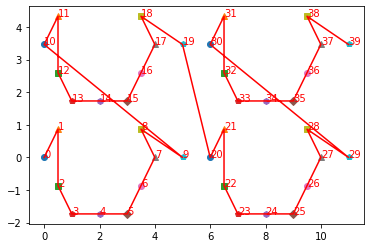

In [77]:
fig = plt.figure()
ax = fig.gca()
model_fin.lat.plot_sites(ax)
model_fin.lat.plot_order(ax)

In [78]:
model_fin.coupling_terms

{'J1': <tenpy.networks.terms.CouplingTerms at 0x7f3f76fb43a0>,
 'J2': <tenpy.networks.terms.CouplingTerms at 0x7f3f76fb4490>,
 'J3': <tenpy.networks.terms.CouplingTerms at 0x7f3f76fb4dc0>}

[[('Sx', 0), ('Sx', 1)],
 [('Sx', 0), ('Sx', 2)],
 [('Sy', 0), ('Sy', 1)],
 [('Sy', 0), ('Sy', 2)],
 [('Sz', 0), ('Sz', 1)],
 [('Sz', 0), ('Sz', 2)],
 [('Sx', 1), ('Sx', 13)],
 [('Sy', 1), ('Sy', 13)],
 [('Sz', 1), ('Sz', 13)],
 [('Sx', 2), ('Sx', 3)],
 [('Sy', 2), ('Sy', 3)],
 [('Sz', 2), ('Sz', 3)],
 [('Sx', 3), ('Sx', 4)],
 [('Sy', 3), ('Sy', 4)],
 [('Sz', 3), ('Sz', 4)],
 [('Sx', 4), ('Sx', 5)],
 [('Sy', 4), ('Sy', 5)],
 [('Sz', 4), ('Sz', 5)],
 [('Sx', 5), ('Sx', 6)],
 [('Sy', 5), ('Sy', 6)],
 [('Sz', 5), ('Sz', 6)],
 [('Sx', 6), ('Sx', 7)],
 [('Sy', 6), ('Sy', 7)],
 [('Sz', 6), ('Sz', 7)],
 [('Sx', 7), ('Sx', 8)],
 [('Sx', 7), ('Sx', 9)],
 [('Sy', 7), ('Sy', 8)],
 [('Sy', 7), ('Sy', 9)],
 [('Sz', 7), ('Sz', 8)],
 [('Sz', 7), ('Sz', 9)],
 [('Sx', 8), ('Sx', 15)],
 [('Sy', 8), ('Sy', 15)],
 [('Sz', 8), ('Sz', 15)],
 [('Sx', 9), ('Sx', 20)],
 [('Sy', 9), ('Sy', 20)],
 [('Sz', 9), ('Sz', 20)],
 [('Sx', 10), ('Sx', 11)],
 [('Sx', 10), ('Sx', 12)],
 [('Sy', 10), ('Sy', 11)],
 [('Sy', 1

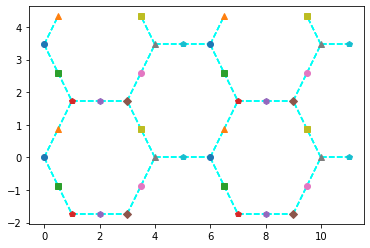

In [79]:
fig = plt.figure()
ax = fig.gca()
model_fin.coupling_terms['J1'].plot_coupling_terms(ax, model_fin.lat)
model_fin.lat.plot_sites(ax)
model_fin.coupling_terms['J1'].to_TermList().terms

[[('Sx', 1), ('Sx', 2)],
 [('Sx', 1), ('Sx', 12)],
 [('Sx', 1), ('Sx', 14)],
 [('Sy', 1), ('Sy', 2)],
 [('Sy', 1), ('Sy', 12)],
 [('Sy', 1), ('Sy', 14)],
 [('Sz', 1), ('Sz', 2)],
 [('Sz', 1), ('Sz', 12)],
 [('Sz', 1), ('Sz', 14)],
 [('Sx', 2), ('Sx', 4)],
 [('Sy', 2), ('Sy', 4)],
 [('Sz', 2), ('Sz', 4)],
 [('Sx', 4), ('Sx', 6)],
 [('Sy', 4), ('Sy', 6)],
 [('Sz', 4), ('Sz', 6)],
 [('Sx', 6), ('Sx', 8)],
 [('Sx', 6), ('Sx', 9)],
 [('Sy', 6), ('Sy', 8)],
 [('Sy', 6), ('Sy', 9)],
 [('Sz', 6), ('Sz', 8)],
 [('Sz', 6), ('Sz', 9)],
 [('Sx', 8), ('Sx', 9)],
 [('Sx', 8), ('Sx', 14)],
 [('Sx', 8), ('Sx', 16)],
 [('Sy', 8), ('Sy', 9)],
 [('Sy', 8), ('Sy', 14)],
 [('Sy', 8), ('Sy', 16)],
 [('Sz', 8), ('Sz', 9)],
 [('Sz', 8), ('Sz', 14)],
 [('Sz', 8), ('Sz', 16)],
 [('Sx', 9), ('Sx', 21)],
 [('Sx', 9), ('Sx', 22)],
 [('Sy', 9), ('Sy', 21)],
 [('Sy', 9), ('Sy', 22)],
 [('Sz', 9), ('Sz', 21)],
 [('Sz', 9), ('Sz', 22)],
 [('Sx', 11), ('Sx', 12)],
 [('Sy', 11), ('Sy', 12)],
 [('Sz', 11), ('Sz', 12)],
 

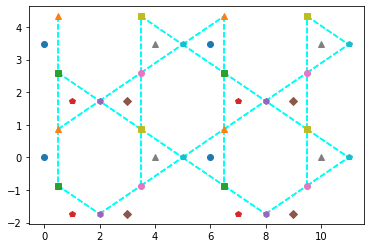

In [80]:
fig = plt.figure()
ax = fig.gca()
model_fin.coupling_terms['J2'].plot_coupling_terms(ax, model_fin.lat)
model_fin.lat.plot_sites(ax)
model_fin.coupling_terms['J2'].to_TermList().terms

[[('Sx', 0), ('Sx', 3)],
 [('Sx', 0), ('Sx', 13)],
 [('Sy', 0), ('Sy', 3)],
 [('Sy', 0), ('Sy', 13)],
 [('Sz', 0), ('Sz', 3)],
 [('Sz', 0), ('Sz', 13)],
 [('Sx', 3), ('Sx', 5)],
 [('Sy', 3), ('Sy', 5)],
 [('Sz', 3), ('Sz', 5)],
 [('Sx', 5), ('Sx', 7)],
 [('Sy', 5), ('Sy', 7)],
 [('Sz', 5), ('Sz', 7)],
 [('Sx', 7), ('Sx', 15)],
 [('Sx', 7), ('Sx', 20)],
 [('Sy', 7), ('Sy', 15)],
 [('Sy', 7), ('Sy', 20)],
 [('Sz', 7), ('Sz', 15)],
 [('Sz', 7), ('Sz', 20)],
 [('Sx', 10), ('Sx', 13)],
 [('Sy', 10), ('Sy', 13)],
 [('Sz', 10), ('Sz', 13)],
 [('Sx', 13), ('Sx', 15)],
 [('Sy', 13), ('Sy', 15)],
 [('Sz', 13), ('Sz', 15)],
 [('Sx', 15), ('Sx', 17)],
 [('Sy', 15), ('Sy', 17)],
 [('Sz', 15), ('Sz', 17)],
 [('Sx', 17), ('Sx', 30)],
 [('Sy', 17), ('Sy', 30)],
 [('Sz', 17), ('Sz', 30)],
 [('Sx', 20), ('Sx', 23)],
 [('Sx', 20), ('Sx', 33)],
 [('Sy', 20), ('Sy', 23)],
 [('Sy', 20), ('Sy', 33)],
 [('Sz', 20), ('Sz', 23)],
 [('Sz', 20), ('Sz', 33)],
 [('Sx', 23), ('Sx', 25)],
 [('Sy', 23), ('Sy', 25)],
 

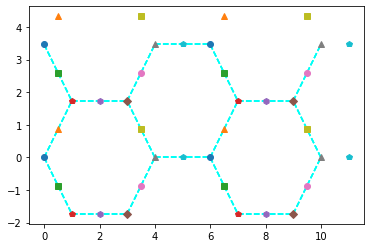

In [81]:
fig = plt.figure()
ax = fig.gca()
model_fin.coupling_terms['J3'].plot_coupling_terms(ax, model_fin.lat)
model_fin.lat.plot_sites(ax)
model_fin.coupling_terms['J3'].to_TermList().terms

## Check correctness of Infinite Models

### Zig-Zag

In [82]:
model_inf = HH_J1J2J3({'Lx':1, 'Ly':2, 'J1': 1.0, 'J2': 0.0, 'J3': 0.0, 'bc_MPS':'infinite', 
                   'conserve':None, 'lattice': HH_Lattice_zigzag, 'bc_x': 'periodic', 'bc_y': 'periodic'})
print(np.max(model_inf.H_MPO.chi))

INFO    : HH_J1J2J3: reading 'lattice'=<class '__main__.HH_Lattice_zigzag'>
INFO    : HH_J1J2J3: reading 'bc_MPS'='infinite'
INFO    : HH_J1J2J3: reading 'conserve'=None
INFO    : HH_J1J2J3: reading 'bc_x'='periodic'
INFO    : HH_J1J2J3: reading 'Lx'=1
INFO    : HH_J1J2J3: reading 'Ly'=2
INFO    : HH_J1J2J3: reading 'bc_y'='periodic'
INFO    : HH_J1J2J3: reading 'J1'=1.0
INFO    : HH_J1J2J3: reading 'J2'=0.0
INFO    : HH_J1J2J3: reading 'J3'=0.0
44


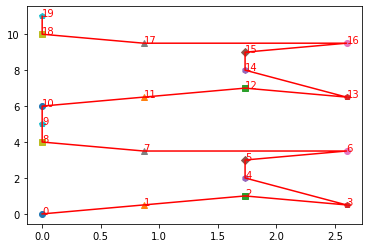

In [83]:
fig = plt.figure()
ax = fig.gca()
model_inf.lat.plot_sites(ax)
model_inf.lat.plot_order(ax)

In [84]:
model_inf.coupling_terms

{'J1': <tenpy.networks.terms.CouplingTerms at 0x7f3f77778df0>,
 'J2': <tenpy.networks.terms.CouplingTerms at 0x7f3f777785e0>,
 'J3': <tenpy.networks.terms.CouplingTerms at 0x7f3f76c8eeb0>}

[[('Sx', 0), ('Sx', 1)],
 [('Sx', 0), ('Sx', 19)],
 [('Sy', 0), ('Sy', 1)],
 [('Sy', 0), ('Sy', 19)],
 [('Sz', 0), ('Sz', 1)],
 [('Sz', 0), ('Sz', 19)],
 [('Sx', 1), ('Sx', 2)],
 [('Sy', 1), ('Sy', 2)],
 [('Sz', 1), ('Sz', 2)],
 [('Sx', 2), ('Sx', 3)],
 [('Sx', 2), ('Sx', 4)],
 [('Sy', 2), ('Sy', 3)],
 [('Sy', 2), ('Sy', 4)],
 [('Sz', 2), ('Sz', 3)],
 [('Sz', 2), ('Sz', 4)],
 [('Sx', 3), ('Sx', 20)],
 [('Sy', 3), ('Sy', 20)],
 [('Sz', 3), ('Sz', 20)],
 [('Sx', 4), ('Sx', 5)],
 [('Sy', 4), ('Sy', 5)],
 [('Sz', 4), ('Sz', 5)],
 [('Sx', 5), ('Sx', 6)],
 [('Sx', 5), ('Sx', 7)],
 [('Sy', 5), ('Sy', 6)],
 [('Sy', 5), ('Sy', 7)],
 [('Sz', 5), ('Sz', 6)],
 [('Sz', 5), ('Sz', 7)],
 [('Sx', 6), ('Sx', 28)],
 [('Sy', 6), ('Sy', 28)],
 [('Sz', 6), ('Sz', 28)],
 [('Sx', 7), ('Sx', 8)],
 [('Sy', 7), ('Sy', 8)],
 [('Sz', 7), ('Sz', 8)],
 [('Sx', 8), ('Sx', 9)],
 [('Sy', 8), ('Sy', 9)],
 [('Sz', 8), ('Sz', 9)],
 [('Sx', 9), ('Sx', 10)],
 [('Sy', 9), ('Sy', 10)],
 [('Sz', 9), ('Sz', 10)],
 [('Sx', 10),

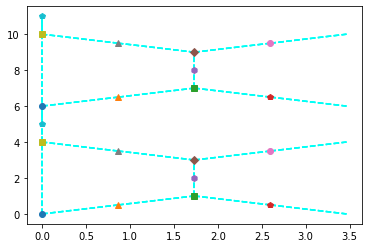

In [85]:
fig = plt.figure()
ax = fig.gca()
model_inf.coupling_terms['J1'].plot_coupling_terms(ax, model_inf.lat)
model_inf.lat.plot_sites(ax)
model_inf.coupling_terms['J1'].to_TermList().terms

[[('Sx', 1), ('Sx', 3)],
 [('Sx', 1), ('Sx', 4)],
 [('Sx', 1), ('Sx', 19)],
 [('Sy', 1), ('Sy', 3)],
 [('Sy', 1), ('Sy', 4)],
 [('Sy', 1), ('Sy', 19)],
 [('Sz', 1), ('Sz', 3)],
 [('Sz', 1), ('Sz', 4)],
 [('Sz', 1), ('Sz', 19)],
 [('Sx', 3), ('Sx', 4)],
 [('Sx', 3), ('Sx', 21)],
 [('Sx', 3), ('Sx', 39)],
 [('Sy', 3), ('Sy', 4)],
 [('Sy', 3), ('Sy', 21)],
 [('Sy', 3), ('Sy', 39)],
 [('Sz', 3), ('Sz', 4)],
 [('Sz', 3), ('Sz', 21)],
 [('Sz', 3), ('Sz', 39)],
 [('Sx', 4), ('Sx', 6)],
 [('Sx', 4), ('Sx', 7)],
 [('Sy', 4), ('Sy', 6)],
 [('Sy', 4), ('Sy', 7)],
 [('Sz', 4), ('Sz', 6)],
 [('Sz', 4), ('Sz', 7)],
 [('Sx', 6), ('Sx', 7)],
 [('Sx', 6), ('Sx', 27)],
 [('Sx', 6), ('Sx', 29)],
 [('Sy', 6), ('Sy', 7)],
 [('Sy', 6), ('Sy', 27)],
 [('Sy', 6), ('Sy', 29)],
 [('Sz', 6), ('Sz', 7)],
 [('Sz', 6), ('Sz', 27)],
 [('Sz', 6), ('Sz', 29)],
 [('Sx', 7), ('Sx', 9)],
 [('Sy', 7), ('Sy', 9)],
 [('Sz', 7), ('Sz', 9)],
 [('Sx', 9), ('Sx', 11)],
 [('Sy', 9), ('Sy', 11)],
 [('Sz', 9), ('Sz', 11)],
 [('Sx'

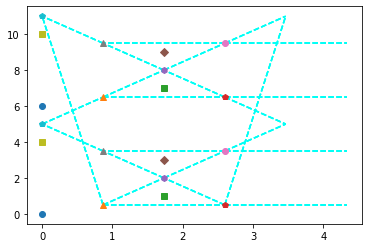

In [86]:
fig = plt.figure()
ax = fig.gca()
model_inf.coupling_terms['J2'].plot_coupling_terms(ax, model_inf.lat)
model_inf.lat.plot_sites(ax)
model_inf.coupling_terms['J2'].to_TermList().terms

[[('Sx', 0), ('Sx', 2)],
 [('Sx', 0), ('Sx', 18)],
 [('Sy', 0), ('Sy', 2)],
 [('Sy', 0), ('Sy', 18)],
 [('Sz', 0), ('Sz', 2)],
 [('Sz', 0), ('Sz', 18)],
 [('Sx', 2), ('Sx', 5)],
 [('Sx', 2), ('Sx', 20)],
 [('Sy', 2), ('Sy', 5)],
 [('Sy', 2), ('Sy', 20)],
 [('Sz', 2), ('Sz', 5)],
 [('Sz', 2), ('Sz', 20)],
 [('Sx', 5), ('Sx', 8)],
 [('Sx', 5), ('Sx', 28)],
 [('Sy', 5), ('Sy', 8)],
 [('Sy', 5), ('Sy', 28)],
 [('Sz', 5), ('Sz', 8)],
 [('Sz', 5), ('Sz', 28)],
 [('Sx', 8), ('Sx', 10)],
 [('Sy', 8), ('Sy', 10)],
 [('Sz', 8), ('Sz', 10)],
 [('Sx', 10), ('Sx', 12)],
 [('Sy', 10), ('Sy', 12)],
 [('Sz', 10), ('Sz', 12)],
 [('Sx', 12), ('Sx', 15)],
 [('Sx', 12), ('Sx', 30)],
 [('Sy', 12), ('Sy', 15)],
 [('Sy', 12), ('Sy', 30)],
 [('Sz', 12), ('Sz', 15)],
 [('Sz', 12), ('Sz', 30)],
 [('Sx', 15), ('Sx', 18)],
 [('Sx', 15), ('Sx', 38)],
 [('Sy', 15), ('Sy', 18)],
 [('Sy', 15), ('Sy', 38)],
 [('Sz', 15), ('Sz', 18)],
 [('Sz', 15), ('Sz', 38)]]

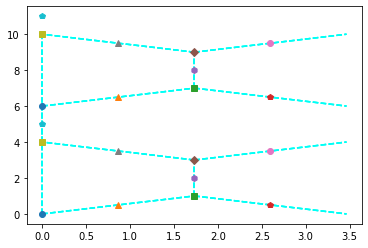

In [87]:
fig = plt.figure()
ax = fig.gca()
model_inf.coupling_terms['J3'].plot_coupling_terms(ax, model_inf.lat)
model_inf.lat.plot_sites(ax)
model_inf.coupling_terms['J3'].to_TermList().terms

### Arm Chair

In [89]:
model_inf = HH_J1J2J3({'Lx':1, 'Ly':2, 'J1': 1.0, 'J2': 0.0, 'J3': 0.0, 'bc_MPS':'infinite', 
                   'conserve':None, 'lattice': HH_Lattice_armchair, 'bc_x': 'periodic', 'bc_y': 'periodic'})
print(np.max(model_inf.H_MPO.chi))

INFO    : HH_J1J2J3: reading 'lattice'=<class '__main__.HH_Lattice_armchair'>
INFO    : HH_J1J2J3: reading 'bc_MPS'='infinite'
INFO    : HH_J1J2J3: reading 'conserve'=None
INFO    : HH_J1J2J3: reading 'bc_x'='periodic'
INFO    : HH_J1J2J3: reading 'Lx'=1
INFO    : HH_J1J2J3: reading 'Ly'=2
INFO    : HH_J1J2J3: reading 'bc_y'='periodic'
INFO    : HH_J1J2J3: reading 'J1'=1.0
INFO    : HH_J1J2J3: reading 'J2'=0.0
INFO    : HH_J1J2J3: reading 'J3'=0.0
38


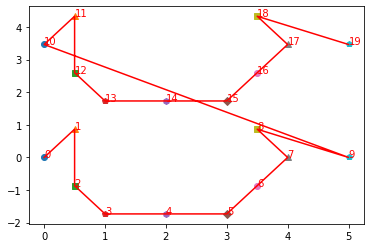

In [90]:
fig = plt.figure()
ax = fig.gca()
model_inf.lat.plot_sites(ax)
model_inf.lat.plot_order(ax)

In [91]:
model_inf.coupling_terms

{'J1': <tenpy.networks.terms.CouplingTerms at 0x7f3f774f11f0>,
 'J2': <tenpy.networks.terms.CouplingTerms at 0x7f3f77550730>,
 'J3': <tenpy.networks.terms.CouplingTerms at 0x7f3f77778c70>}

[[('Sx', 0), ('Sx', 1)],
 [('Sx', 0), ('Sx', 2)],
 [('Sy', 0), ('Sy', 1)],
 [('Sy', 0), ('Sy', 2)],
 [('Sz', 0), ('Sz', 1)],
 [('Sz', 0), ('Sz', 2)],
 [('Sx', 1), ('Sx', 13)],
 [('Sy', 1), ('Sy', 13)],
 [('Sz', 1), ('Sz', 13)],
 [('Sx', 2), ('Sx', 3)],
 [('Sy', 2), ('Sy', 3)],
 [('Sz', 2), ('Sz', 3)],
 [('Sx', 3), ('Sx', 4)],
 [('Sx', 3), ('Sx', 11)],
 [('Sy', 3), ('Sy', 4)],
 [('Sy', 3), ('Sy', 11)],
 [('Sz', 3), ('Sz', 4)],
 [('Sz', 3), ('Sz', 11)],
 [('Sx', 4), ('Sx', 5)],
 [('Sy', 4), ('Sy', 5)],
 [('Sz', 4), ('Sz', 5)],
 [('Sx', 5), ('Sx', 6)],
 [('Sx', 5), ('Sx', 18)],
 [('Sy', 5), ('Sy', 6)],
 [('Sy', 5), ('Sy', 18)],
 [('Sz', 5), ('Sz', 6)],
 [('Sz', 5), ('Sz', 18)],
 [('Sx', 6), ('Sx', 7)],
 [('Sy', 6), ('Sy', 7)],
 [('Sz', 6), ('Sz', 7)],
 [('Sx', 7), ('Sx', 8)],
 [('Sx', 7), ('Sx', 9)],
 [('Sy', 7), ('Sy', 8)],
 [('Sy', 7), ('Sy', 9)],
 [('Sz', 7), ('Sz', 8)],
 [('Sz', 7), ('Sz', 9)],
 [('Sx', 8), ('Sx', 15)],
 [('Sy', 8), ('Sy', 15)],
 [('Sz', 8), ('Sz', 15)],
 [('Sx', 9), 

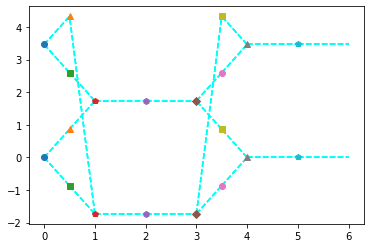

In [92]:
fig = plt.figure()
ax = fig.gca()
model_inf.coupling_terms['J1'].plot_coupling_terms(ax, model_inf.lat)
model_inf.lat.plot_sites(ax)
model_inf.coupling_terms['J1'].to_TermList().terms

[[('Sx', 1), ('Sx', 2)],
 [('Sx', 1), ('Sx', 12)],
 [('Sx', 1), ('Sx', 14)],
 [('Sy', 1), ('Sy', 2)],
 [('Sy', 1), ('Sy', 12)],
 [('Sy', 1), ('Sy', 14)],
 [('Sz', 1), ('Sz', 2)],
 [('Sz', 1), ('Sz', 12)],
 [('Sz', 1), ('Sz', 14)],
 [('Sx', 2), ('Sx', 4)],
 [('Sx', 2), ('Sx', 11)],
 [('Sy', 2), ('Sy', 4)],
 [('Sy', 2), ('Sy', 11)],
 [('Sz', 2), ('Sz', 4)],
 [('Sz', 2), ('Sz', 11)],
 [('Sx', 4), ('Sx', 6)],
 [('Sx', 4), ('Sx', 11)],
 [('Sx', 4), ('Sx', 18)],
 [('Sy', 4), ('Sy', 6)],
 [('Sy', 4), ('Sy', 11)],
 [('Sy', 4), ('Sy', 18)],
 [('Sz', 4), ('Sz', 6)],
 [('Sz', 4), ('Sz', 11)],
 [('Sz', 4), ('Sz', 18)],
 [('Sx', 6), ('Sx', 8)],
 [('Sx', 6), ('Sx', 9)],
 [('Sx', 6), ('Sx', 18)],
 [('Sy', 6), ('Sy', 8)],
 [('Sy', 6), ('Sy', 9)],
 [('Sy', 6), ('Sy', 18)],
 [('Sz', 6), ('Sz', 8)],
 [('Sz', 6), ('Sz', 9)],
 [('Sz', 6), ('Sz', 18)],
 [('Sx', 8), ('Sx', 9)],
 [('Sx', 8), ('Sx', 14)],
 [('Sx', 8), ('Sx', 16)],
 [('Sy', 8), ('Sy', 9)],
 [('Sy', 8), ('Sy', 14)],
 [('Sy', 8), ('Sy', 16)],
 [(

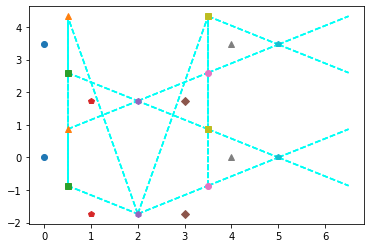

In [93]:
fig = plt.figure()
ax = fig.gca()
model_inf.coupling_terms['J2'].plot_coupling_terms(ax, model_inf.lat)
model_inf.lat.plot_sites(ax)
model_inf.coupling_terms['J2'].to_TermList().terms

[[('Sx', 0), ('Sx', 3)],
 [('Sx', 0), ('Sx', 13)],
 [('Sy', 0), ('Sy', 3)],
 [('Sy', 0), ('Sy', 13)],
 [('Sz', 0), ('Sz', 3)],
 [('Sz', 0), ('Sz', 13)],
 [('Sx', 3), ('Sx', 5)],
 [('Sx', 3), ('Sx', 10)],
 [('Sy', 3), ('Sy', 5)],
 [('Sy', 3), ('Sy', 10)],
 [('Sz', 3), ('Sz', 5)],
 [('Sz', 3), ('Sz', 10)],
 [('Sx', 5), ('Sx', 7)],
 [('Sx', 5), ('Sx', 17)],
 [('Sy', 5), ('Sy', 7)],
 [('Sy', 5), ('Sy', 17)],
 [('Sz', 5), ('Sz', 7)],
 [('Sz', 5), ('Sz', 17)],
 [('Sx', 7), ('Sx', 15)],
 [('Sx', 7), ('Sx', 20)],
 [('Sy', 7), ('Sy', 15)],
 [('Sy', 7), ('Sy', 20)],
 [('Sz', 7), ('Sz', 15)],
 [('Sz', 7), ('Sz', 20)],
 [('Sx', 10), ('Sx', 13)],
 [('Sy', 10), ('Sy', 13)],
 [('Sz', 10), ('Sz', 13)],
 [('Sx', 13), ('Sx', 15)],
 [('Sy', 13), ('Sy', 15)],
 [('Sz', 13), ('Sz', 15)],
 [('Sx', 15), ('Sx', 17)],
 [('Sy', 15), ('Sy', 17)],
 [('Sz', 15), ('Sz', 17)],
 [('Sx', 17), ('Sx', 30)],
 [('Sy', 17), ('Sy', 30)],
 [('Sz', 17), ('Sz', 30)]]

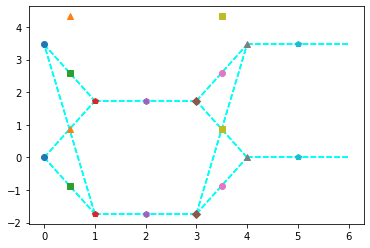

In [94]:
fig = plt.figure()
ax = fig.gca()
model_inf.coupling_terms['J3'].plot_coupling_terms(ax, model_inf.lat)
model_inf.lat.plot_sites(ax)
model_inf.coupling_terms['J3'].to_TermList().terms

# Run DMRG

In [ ]:
def run_DMRG_infinite(Js, chi_max, Lx, Ly, conserve='Sz', lattice=HH_Lattice_slant, psi=None):       
    model = HH_J1J2J3({'Lx': Lx, 'Ly': Ly, 'J1': Js[0], 'J2': Js[1], 'J3': Js[2], 'bc_MPS': 'infinite', 'conserve': conserve, 
                       'bc_x': 'periodic', 'bc_y': 'periodic', 'lattice': lattice})
    if psi is None:
        if lattice == HH_Lattice_vertical:
            psi = MPS.from_product_state(model.lat.mps_sites(), (["up","down","up","down","up","down","up","down","up","down"]*Lx*Ly), bc='infinite')
        else:
            psi = MPS.from_product_state(model.lat.mps_sites(), (["up","down","up","down","up"]*Lx*Ly), bc='infinite')
    dmrg_params = {
        'trunc_params': {
            'chi_max': chi_max,
            'svd_min': 1.e-8,
        },
        'max_E_err': 1e-8,
        'max_S_err': 1e-3,
        'norm_tol': 1e-4,
        'max_sweeps': 200,  # NOTE: this is not enough to fully converge at the critical point!
        'min_sweeps': 50,
        'mixer': True
    }
    engine = dmrg.TwoSiteDMRGEngine(psi, model, dmrg_params)
    E0, psi = engine.run()
    psi.canonical_form()
    xi = psi.correlation_length()
    return E0, psi, xi

def run_DMRG_finite(Js, chi_max, L, conserve='Sz', lattice=HH_Lattice_slant, psi=None):
    model = HH_J1J2J3({'Lx': Lx, 'Ly': Ly, 'J1': Js[0], 'J2': Js[1], 'J3': Js[2], 'bc_MPS': 'finite', 'conserve': conserve, 
                       'bc_x': 'open', 'bc_y': 'open', 'lattice': lattice})
    
    if psi is None:
        if lattice == HH_Lattice_vertical:
            psi = MPS.from_product_state(model.lat.mps_sites(), (["up","down","up","down","up","down","up","down","up","down"]*Lx*Ly), bc='finite')
        else:
            psi = MPS.from_product_state(model.lat.mps_sites(), (["up","down","up","down","up"]*Lx*Ly), bc='finite')
    dmrg_params = {
        'trunc_params': {
            'chi_max': chi_max,
            'svd_min': 1.e-8,
        },
        'max_E_err': 1e-7,
        'max_S_err': 1e-4,
        'norm_tol': 1e-4,
        'max_sweeps': 200,  # NOTE: this is not enough to fully converge at the critical point!
        'min_sweeps': 20,
        'mixer': True,
        'mixer_params': {
            'amplitude': 1,
            'decay': 2,
            'disable_after': 20,
        },
    }
    engine = dmrg.TwoSiteDMRGEngine(psi_PS, model, dmrg_params)
    engine.init_env(model=model)
    E0, psi = engine.run()
    psi.canonical_form()
    return E0, psi